In [18]:
!pip install yfinance --quiet

import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

In [24]:
import pandas as pd
import yfinance as yf
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load saved data
data = pd.read_csv(
    "sp500_data.csv",
    index_col=0,
    parse_dates=True,
    date_format="%Y-%m-%d"
)

# ✅ Ensure 'Close' column is numeric
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Drop rows with any NaNs (just in case)
data = data.dropna(subset=['Close'])

# Compute log returns
prices = data['Close']
log_returns = np.log(prices / prices.shift(1)).dropna().values.astype(np.float32)

# Normalize
mean = log_returns.mean()
std = log_returns.std()
log_returns = (log_returns - mean) / std

# Create sequences
seq_length = 60
X = [log_returns[i:i + seq_length] for i in range(len(log_returns) - seq_length)]
X = np.array(X)

# Convert to tensor
# X_tensor = torch.tensor(X, dtype=torch.float32)
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)

dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Prepared {X_tensor.shape[0]} sequences of length {seq_length}")


Prepared 3712 sequences of length 60


In [25]:
print(next(iter(loader))[0].shape)


torch.Size([64, 60, 1])


In [26]:
class TimeGrad(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=1):
        super(TimeGrad, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.denoise_head = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x_embed = self.embedding(x)
        out, _ = self.gru(x_embed)
        return self.denoise_head(out)

# Initialize model
model = TimeGrad()


In [27]:
# # DDPM-style schedule
# timesteps = 100
# betas = torch.linspace(1e-4, 0.02, timesteps)
# alphas = 1.0 - betas
# alpha_bars = torch.cumprod(alphas, dim=0).to(device)

import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM-style schedule
timesteps = 100
betas = torch.linspace(1e-4, 0.02, timesteps)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0).to(device)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

n_epochs = 5
for epoch in range(n_epochs):
    total_loss = 0
    for (x_0,) in loader:
        x_0 = x_0.to(device)
        B, L, D = x_0.shape  # should be (batch, 60, 1)

        t = torch.randint(0, timesteps, (B,), dtype=torch.long).to(device)
        alpha_bar = alpha_bars[t].view(B, 1, 1).expand(B, L, 1)

        noise = torch.randn_like(x_0)
        one_minus_ab = 1.0 - alpha_bar

        # 💥 Debug: Check shapes
        assert x_0.shape == alpha_bar.shape == noise.shape, f"Shapes mismatch: x_0: {x_0.shape}, alpha_bar: {alpha_bar.shape}, noise: {noise.shape}"

        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(one_minus_ab) * noise

        predicted_noise = model(x_t)
        loss = loss_fn(predicted_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.4f}")


Epoch 1: Loss = 0.7716
Epoch 2: Loss = 0.7166
Epoch 3: Loss = 0.7031
Epoch 4: Loss = 0.7105
Epoch 5: Loss = 0.7001


In [29]:
# Sampling Function

def sample_timegrad(model, seq_len=60, timesteps=100, n_samples=3):
    model.eval()
    device = next(model.parameters()).device  # get model's device

    # DDPM schedule on correct device
    betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    x_t = torch.randn(n_samples, seq_len, 1).to(device)  # start with Gaussian noise

    with torch.no_grad():
        for t in reversed(range(timesteps)):
            alpha = alphas[t]
            beta = betas[t]
            alpha_bar = alpha_bars[t]

            z = torch.randn_like(x_t) if t > 0 else 0
            predicted_noise = model(x_t)

            x_t = (1 / torch.sqrt(alpha)) * (
                x_t - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * predicted_noise
            ) + torch.sqrt(beta) * z

    return x_t.cpu().squeeze(-1)  # return to CPU for plotting



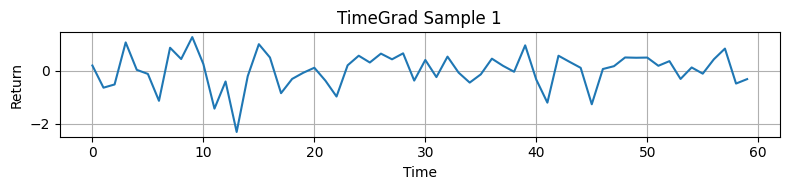

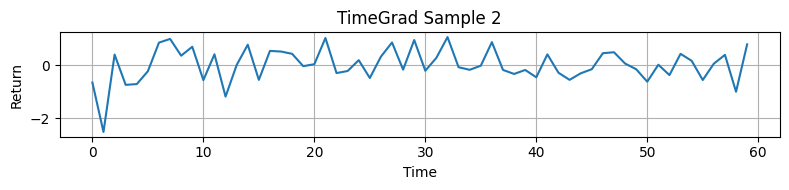

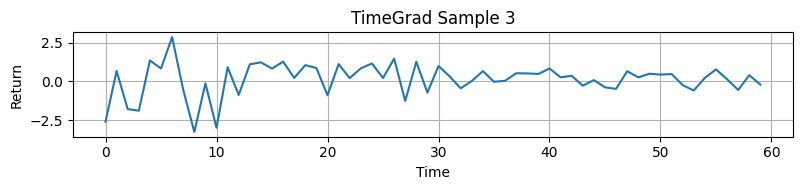

In [30]:
# Generate and Plot Synthetic Returns

generated = sample_timegrad(model, n_samples=3)

for i, seq in enumerate(generated):
    plt.figure(figsize=(8, 2))
    plt.plot(seq.numpy())
    plt.title(f"TimeGrad Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

